### Phys 629, Fall 2023, University of Mississippi


# Lecture 4, Chapter 3: Probability and Statistical Distributions

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 3. 

***Exercises required for class participation are in <font color='red'>red</font>.***

## Descriptive statistics <a class="anchor" id="one"></a>

As we've said, our goal is to estimate $h(x)$ given some measured data, allowing us to reconstruct the data-based distribution $f(x)$. An arbitrary distribution can be characterized by **location** parameters (i.e., position), **scale** parameters (i.e., width), and **shape** parameters. These parameters are called ***descriptive statistics***.

The distribution we're trying to characterize could be anything, e.g., (from my field) the distribution of masses of binary black-hole systems as discovered by gravitational-wave detectors. We really don't know the answer to this well, and the problem is made more complicated by things like detector selection effects (heavier systems are more likely to be observed), and blurring effects from measurement precision.

<font color='red'>Execute this cell</font>

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

<font color='red'>Execute this cell</font>

In [2]:
#------------------------------------------------------------
# Let's generate some data: a mix of several Cauchy distributions
random_state = np.random.RandomState(seed=0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
hx = lambda x: sum([f * scipy.stats.cauchy(mu, gamma).pdf(x)
                    for (mu, gamma, f) in mu_gamma_f])
data = np.concatenate([scipy.stats.cauchy(mu, gamma).rvs(int(f * N), 
                                                         random_state=random_state)
                       for (mu, gamma, f) in mu_gamma_f])
random_state.shuffle(data)
data = data[data > -10]
data = data[data < 30]
print(data)

[ 6.31554336  9.52074632 12.67987044 ...  7.60902873  7.36536874
  4.47255945]


<font color='red'>Execute this cell</font>

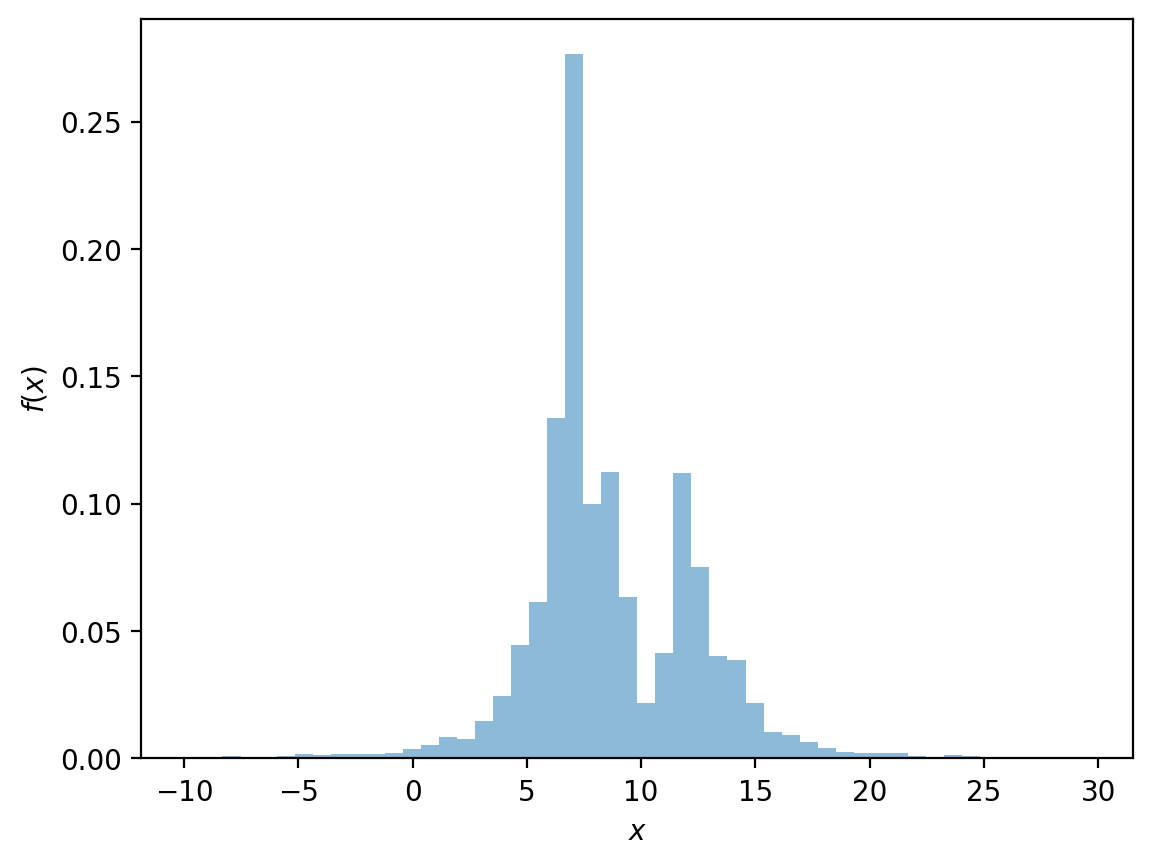

In [3]:
# make a histogram to get an idea of what the distribution looks like
plt.hist(data, bins=50, density=True, alpha=0.5);
plt.xlabel('$x$');
plt.ylabel('$f(x)$');  

We all know that the **mean** of a sample is 

$$\bar{x} = \frac{1}{N}\sum_{i=1}^N x_i$$ 

This is actually known as the **sample arithmetic mean**, and derives from *Monte Carlo integration* to get the first moment of the distribution, i.e. 

$$\mu = E(x) = \langle x \rangle = \int_{-\infty}^{\infty} x\, h(x)\,dx \approx \frac{1}{N}\sum_{i=1}^N x_i $$

where $\{x_i\}$ are random samples from the properly normalized $h(x)$, and $E(\cdot)$ means the **expectation value**. In general we can use random sampling and Monte Carlo integration to deduce integrals over distributions such that 

$$\int_{-\infty}^{\infty} g(x) h(x)\,dx \approx \frac{1}{N}\sum_{i=1}^N g(x_i)$$

You can read more on Monte Carlo and Importance Sampling here: https://web.ornl.gov/~kentpr/thesis/pkthnode19.html

[This is a GW paper where imporance sampling is used.](https://arxiv.org/abs/1905.05477)

<font color='red'>Execute this cell</font>

In [4]:
mean = np.mean(data)
print(mean)

8.707331724932475


While it's most common to compute the mean, it may surprise you to learn that some distributions do not have formally calculable means (integration gives infinity). In these and other cases, the **median** is a more *robust* estimator of the (true) mean location of the distribution.  That's because it is less affected by **outliers**.

To understand the previous statement, think about multiplying all numbers above the 50th percentile (i.e. the median) by 100, or even just replacing them with larger numbers. The mean would be strongly affected by these corrupted points, but **cumulative statistics based on the ordering of samples would remain unaffected by the outlier corruption**.

<font color='red'>Execute this cell.  Think about and discuss what it is doing.</font>

In [5]:
median = np.median(data)

mask = data > 15
data2 = data.copy()
data2[mask] = 100

newmedian = np.median(data2)
newmean = np.mean(data2)

print(median, newmedian)
print(mean, newmean)

7.665858989040229 7.665858989040229
8.707331724932475 12.230618259322716


<font color='red'>Repeat the above masking investigation, but this time multiply all samples above $15$ by a factor of 10. Do you get a similar effect?</font>

In [6]:
median = np.median(data)

mask = data > 15
data2 = data.copy()
data2[mask] = 1000

newmedian = np.median(data2)
newmean = np.mean(data2)

print(median, newmedian)
print(mean, newmean)

7.665858989040229 7.665858989040229
8.707331724932475 50.870226662341274


Median remained unchanged, but the mean increased greatly.

Other descriptive statistics are related to higher order moments of the distribution. Beyond the "average" *location* value, we'd like to know something about **deviations** from the average (which is related to the *shape* of the distribution).  The simplest thing to compute is deviation from mean $$d_i = x_i - \mu.$$  However, the average deviation is zero by definition of the mean.  The next simplest thing to do is to compute the **mean absolute deviation (MAD)**:

$$\frac{1}{N}\sum|x_i-\mu|,$$

but the absolute values can hide the true scatter of the distribution [in some cases (see here)](http://www.mathsisfun.com/data/standard-deviation.html).  So the next simplest thing to do is to square the differences $$\sigma^2 = \frac{1}{N}\sum(x_i-\mu)^2,$$ which we call the **variance**.

The *variance* $V$ is just expectation value of $(x-\mu)^2$ (and related to the 2nd moment)

$$\sigma^2 = V = E((x-\mu)^2)\int_{-\infty}^{\infty}  (x-\mu)^2 h(x) dx,$$

where $\sigma$ is the **standard deviation**. Again, the integral gets replaced by a sum for discrete distributions. While most familiar for Gaussian distributions, you can compute the variance even if your distribution is not Gaussian.  

<font color='red'>Execute this cell</font>

In [7]:
var = np.var(data)
std = np.std(data)
print(var, std)

14.109284000694963 3.75623268724063


**$P\%$ quantiles (or the $p^\mathrm{th}$ percentile, $q_p$)** are computed as
$$\frac{p}{100} = H(q_p) = \int_{-\infty}^{q_p}h(x) dx$$

The full integral from $-\infty$ to $\infty$ is 1 (100%).  So, here you are looking for the value of x that accounts for $p$ percent of the distribution.

For example, the 25th, 50th, and 75th percentiles:

<font color='red'>Execute this cell</font>

In [8]:
q25, q50, q75 = np.percentile(data, [25, 50, 75])
print(q25, q50, q75)

6.674244809830177 7.665858989040229 11.61720224123862


The **interquartile range** is the difference between the 25th and 75th percentiles, $q_{75} - q_{25}$.

Just as with the median, the interquartile range is a more *robust* estimator of the scale of a distribution than the standard deviation.  So, one can create a width estimater (at least for a Gaussian) from the interquartile range as

$$\sigma_G = 0.7413\times(q_{75} - q_{25})$$  

The normalization makes it *unbiased* for a perfect Gaussian (more on that later).

<font color='red'>Execute this cell. Think about and discuss the results.</font>

In [9]:
from astroML import stats as astroMLstats

# original data
print(astroMLstats.sigmaG(data), np.std(data))

# corrupted by outliers
print(astroMLstats.sigmaG(data2), np.std(data2))

3.6642198268924555 3.75623268724063
3.6642198268924555 201.04931312718134


<font color='red'>Execute this cell. Cumulative statistics take longer to compute, but are more robust.</font>

In [10]:
%timeit np.mean(data), np.std(data)
%timeit np.median(data), astroMLstats.sigmaG(data)

46.5 µs ± 8.13 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
526 µs ± 64.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<font color='red'>Make a plot of a histogram of the original data array, and add vertical lines at the 25th, 50th, and 75th percentiles.</font>

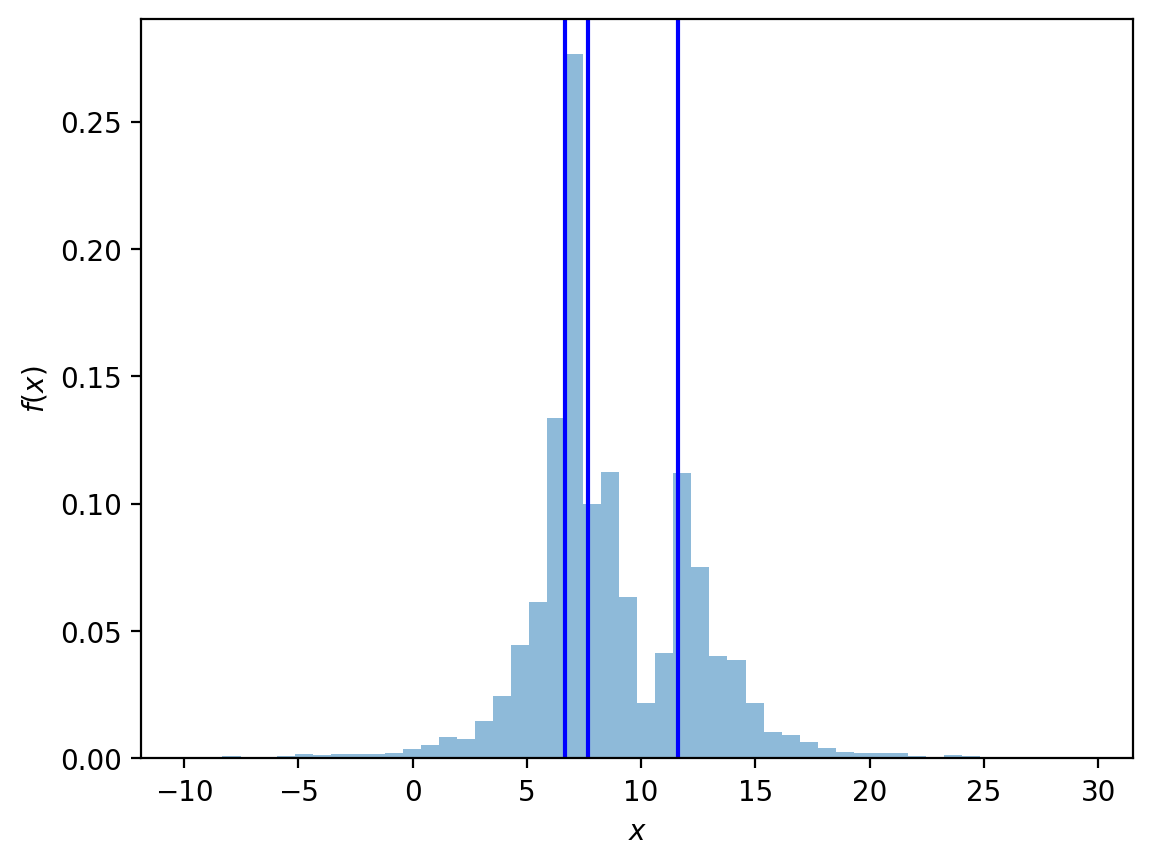

In [15]:
plt.hist(data, bins=50, density=True, alpha=0.5);
plt.xlabel('$x$');
plt.ylabel('$f(x)$'); 
plt.axvline(x= q25, color = 'b', label = 'axvline - full height');
plt.axvline(x= q50, color = 'b', label = 'axvline - full height');
plt.axvline(x= q75, color = 'b', label = 'axvline - full height');

The **mode** is the most probable value, determined from the peak of the distribution, which is the value where the derivative is 0 (i.e. the turning point):

$$ \left(\frac{dh(x)}{dx}\right)_{x_m} = 0$$

Another way to estimate the mode (at least for a Gaussian distribution) is

$$x_m = 3q_{50} - 2\mu$$

<font color='red'>Execute this cell</font>

In [16]:
mode = 3*q50 - 2*mean
print(mode, mean, median)

# Note: don't rely on scipy.stats.mode()
# It gives the most common value of an array, 
# but we have a random sample of unique draws

5.5829135172557365 8.707331724932475 7.665858989040229


Other useful ***shape*** measures include the "higher order" moments (the **skewness** and **kurtosis**):

$$\mathbf{Skewness}\quad\quad \Sigma = \int_{-\infty}^{\infty}  \left(\frac{x-\mu}{\sigma}\right)^3 h(x) dx,$$
 
$$\mathbf{Kurtosis}\quad\quad K = \int_{-\infty}^{\infty}  \left(\frac{x-\mu}{\sigma}\right)^4 h(x) dx  - 3.$$

The skewness measures the distribution's *asymmetry*. Distribution's with long tails to larger $x$ values have positive $\Sigma$. 

The kurtosis measures how peaked or flat-topped a distribution is, with strongly peaked ones being positive and flat-topped ones being negative. $K$ is calibrated to a Gaussian distribution (hence the subtraction of $3$).

![https://www.astroml.org/_images/fig_kurtosis_skew_1.png](https://www.astroml.org/_images/fig_kurtosis_skew_1.png)

<font color='red'>Execute this cell</font>

In [17]:
skew = scipy.stats.skew(data)
kurt = scipy.stats.kurtosis(data)
print(skew, kurt)

0.3722396543172858 2.883303542073137


<font color='red'>Execute this cell</font>

In [18]:
# Summary descriptive statistics for our distribution
print("Location: ", mean, median, mode)
print("Scale: ", var, std, astroMLstats.sigmaG(data))
print("Shape: ", skew, kurt)
print("Some percentiles: ", q25, q50, q75)

Location:  8.707331724932475 7.665858989040229 5.5829135172557365
Scale:  14.109284000694963 3.75623268724063 3.6642198268924555
Shape:  0.3722396543172858 2.883303542073137
Some percentiles:  6.674244809830177 7.665858989040229 11.61720224123862


## Summary
![Summary of various estimaters](figures/p8.png)

## Sample versus Population statistics <a class="anchor" id="two"></a>

Statistics estimated from the *data* are called **sample statistics** as compared to **population statistics** derived from knowing the functional form of the pdf.

Specifically, $\mu$ is the **population mean**, i.e., it is the expecation value of $x$ for $h(x)$.  But we don't *know* $h(x)$.  So the **sample mean**, $\overline{x}$, is an ***estimator*** of $\mu$, defined as

$$\overline{x} \equiv \frac{1}{N}\sum_{i=1}^N x_i,$$

which we determine from the data itself.

Instead of the **population variance** $\sigma^2$, we have the **sample variance**, $s^2$, where

$$s^2 = \frac{1}{N-1}\sum_{i=1}^N(x_i-\overline{x})^2$$

The $N-1$ denominator (instead of $N$) accounts for the fact that we determine $\overline{x}$ from the data itself instead of using a known $\mu$. Ideally one tries to work in a regime where $N$ is large enough that we can be lazy and ignore this. 

So the mean and variance of a distribution are $\mu$ and $\sigma^2$.  The *estimators* of them are $\overline{x}$ (or $\hat{x}$) and $s^2$, respectively.

### Uncertainty of sample statistics

We would also like to know the uncertainty of our estimates $\overline{x}$ and $s$.  Note that $s$ is the width estimate of the underlying distribution; it is **NOT** the uncertainty of $\overline{x}$. Rather the uncertainty of $\overline{x}$, $\sigma_{\overline{x}}$ is 

$$ \sigma_{\overline{x}} = \frac{s}{\sqrt{N}},$$

which we call the **standard error of the mean**. The uncertainty of $s$ itself is

$$\sigma_s = \frac{s}{\sqrt{2(N-1)}} = \frac{1}{\sqrt{2}}\sqrt{\frac{N}{N-1}}\sigma_{\overline{x}}.$$

Note that for large $N$, $\sigma_{\overline{x}} \sim \sqrt{2}\sigma_s$ and for small $N$, $\sigma_s$ is not much smaller than $s$.  

![Summary of various estimaters](figures/p10.png)
![Summary of various estimaters](figures/p11.png)